# Практика №1
___

## 1. Загрузка и подготовка данных
___

**Описание файла:<br>**
Источник: Данные взяты из файла '2-MP-nauka_2024.xlsx', таблица 1.
Это данные федерального статистического наблюдения по форме № 2-МП (наука) за 2024 год, предоставленные Росстатом. 
Содержание: Таблица содержит информацию о количестве малых предприятий и численности их работников, выполнявших научные исследования и разработки (НИР). Данные сгруппированы по субъектам Российской Федерации. Основные показатели:
Число предприятий, выполнявших НИР (единицы).
Общая численность работников, занятых в НИР (человек).
Разбивка работников по категориям: исследователи, техники, вспомогательный и прочий персонал.
Численность исследователей в возрасте до 39 лет (человек).
Число предприятий, работавших по госконтрактам (единицы).
Данные измеряются в абсолютных величинах (количество предприятий или человек).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Перед началом работы требовалось импортировать библиотеки, которые будут выполнять функции для анализа:
 - pandas: для работы с данными в виде таблиц (DataFrame).
 - numpy: для математических и научных вычислений.
 - matplotlib.pyplot и seaborn: для создания красивых графиков и диаграмм.
 - scipy.stats: для выполнения сложных статистических расчетов и тестов.

Следующим шагом стало считывание файла с информацией, была выбрана первая таблица 1.
При загрузке файла мы сталкиваемся с несколькими трудностями:
 1. В файле есть несколько строк заголовка, которые нужно пропустить. Мы пропускаем первые 7 строк.
 2. Названия колонок прич чтении отсутствуют. Мы зададим их вручную для удобства.
 3. В данных есть пропуски и нечисловые значения ('‒', '...'), которые нужно будет обработать.
<br>В блоке кода определяем названия колонок для нашего DataFrame, так как изначальные названия не были считаны с файла xlsx. Также не считываем столбец "Код ОКАТО" так как он не несёт смысловой нагрузки в нашей работе, указания субъекта РФ будет достаточно.
В ниже представленных данных, не все ячейки содержат числовые значения, что необходимо учитывать при дальнейшем анализе:
"..." - Данные не размещаются в целях обеспечения конфиденциальности первичных статистических данных, полученных от организаций, в соответствии с Федеральным законом от 29.11.2007 № 282-ФЗ (ст.4, п.5; ст. 9. п.1);
"-" - Явление отсутствует

In [78]:
file_path = '2-MP-nauka_2024.xlsx'
column_names = [
'region', 'num_enterprises', 'total_employees',
'researchers', 'technicians', 'aux_staff', 'other_staff',
'researchers_under_39', 'gov_contract_enterprises'
]
columns_to_read = 'A,C:J' # Читать A, затем C до J включительно
df = pd.read_excel(file_path, sheet_name='таблица 1', names=column_names, usecols=columns_to_read, skiprows=7, thousands=' ')

Для удобной работы с данными заменим нечисловые значения в таблицы на значение "Nan", для корректной обработки библиотекой pandas. Также преобразуем все столбцы кроме первого в числовой формат, в случае если внутри ячейки содержится какое-либо ещё значение кроме числовых и уже ранее обработанных значений заменим их также на "Nan". Все строки, не содержащие какой-либо информации удалим. Для дальнейших действий создадим 2 отдельных DataFrame, которые будут включать в себя данные по федереальным округам исключая данные по субъектам РФ и наоборот - данные по субъектам исключая данные по регионам. Убираем строки с названием страны и пустые строки в названии региона. Последним действием в данном пункте удаляем последние две строки, которые не несут полезной информации.

In [80]:
# Заменяются нечисловые маркеры пропусков ('‒', '...') на специальное значение NaN (Not a Number), которое pandas умеет корректно обрабатывать.
df.replace(['‒', '...'], np.nan, inplace=True)

# Преобразуются все столбцы, кроме первого (название региона), в числовой формат.
# 'coerce' означает, что если значение не может быть преобразовано в число, оно станет NaN.
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
        
# Удаляем строки, где нет вообще никаких данных (полностью пустые)
df.dropna(how='all', inplace=True)
    
# Отдельный DataFrame `df_regions`, который содержит данные только по отдельным субъектам РФ, исключая строки с агрегированными данными по федеральным округам и всей стране..
federal_districts = [
    "Центральный федеральный округ", "Северо-Западный федеральный округ",
    "Южный федеральный округ", "Северо-Кавказский федеральный округ",
    "Приволжский федеральный округ", "Уральский федеральный округ",
    "Сибирский федеральный округ", "Дальневосточный федеральный округ",
    "Ненецкий автономный округ", "Ханты-Мансийский автономный округ - Югра",
    "Ямало-Ненецкий автономный округ", "Чукотский автономный округ" 
]

df_districts = df[df['region'].isin(federal_districts)].copy()

# Убираются строки с названием страны, округов и пустые строки в названии региона
df_regions = df[
    ~df['region'].isin(['Российская Федерация '] + federal_districts) &
    df['region'].notna()
].reset_index(drop=True)
df_regions = df_regions.iloc[:-2]

**После проведения подготовительных действий перейдём к расчёту статистических данных.**

___
## 2. Формальное представление данных
___

В данном пункте продемонстрируем типы данных в таблице и пример данных, содержащихся в ней.

In [24]:
df_regions.info()
df_regions.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   region                    84 non-null     object 
 1   num_enterprises           63 non-null     float64
 2   total_employees           36 non-null     float64
 3   researchers               32 non-null     float64
 4   technicians               29 non-null     float64
 5   aux_staff                 25 non-null     float64
 6   other_staff               19 non-null     float64
 7   researchers_under_39      27 non-null     float64
 8   gov_contract_enterprises  37 non-null     float64
dtypes: float64(8), object(1)
memory usage: 6.0+ KB


,region,num_enterprises,total_employees,researchers,technicians,aux_staff,other_staff,researchers_under_39,gov_contract_enterprises
0,Белгородская область,9.0,60.0,12.0,40.0,NaN,NaN,6.0,1.0
1,Брянская область,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,Владимирская область,7.0,98.0,45.0,NaN,21.0,NaN,NaN,1.0
3,Воронежская область,15.0,416.0,187.0,80.0,82.0,67.0,90.0,6.0
4,Ивановская область,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...
79,Хабаровский край,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,Амурская область,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,Магаданская область,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,Сахалинская область,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


По полученным данным можно с уверенностью сказать, что все числовые значения представлены в подходящем типе данных, который обеспечит совместимость с числовыми функциями. Также выведенные данные позволяют оценить полученное форматирование.

___
## 3. Наглядное представление данных
___

В данном пункте представим в виде различных графиков данные из таблицы регионов.

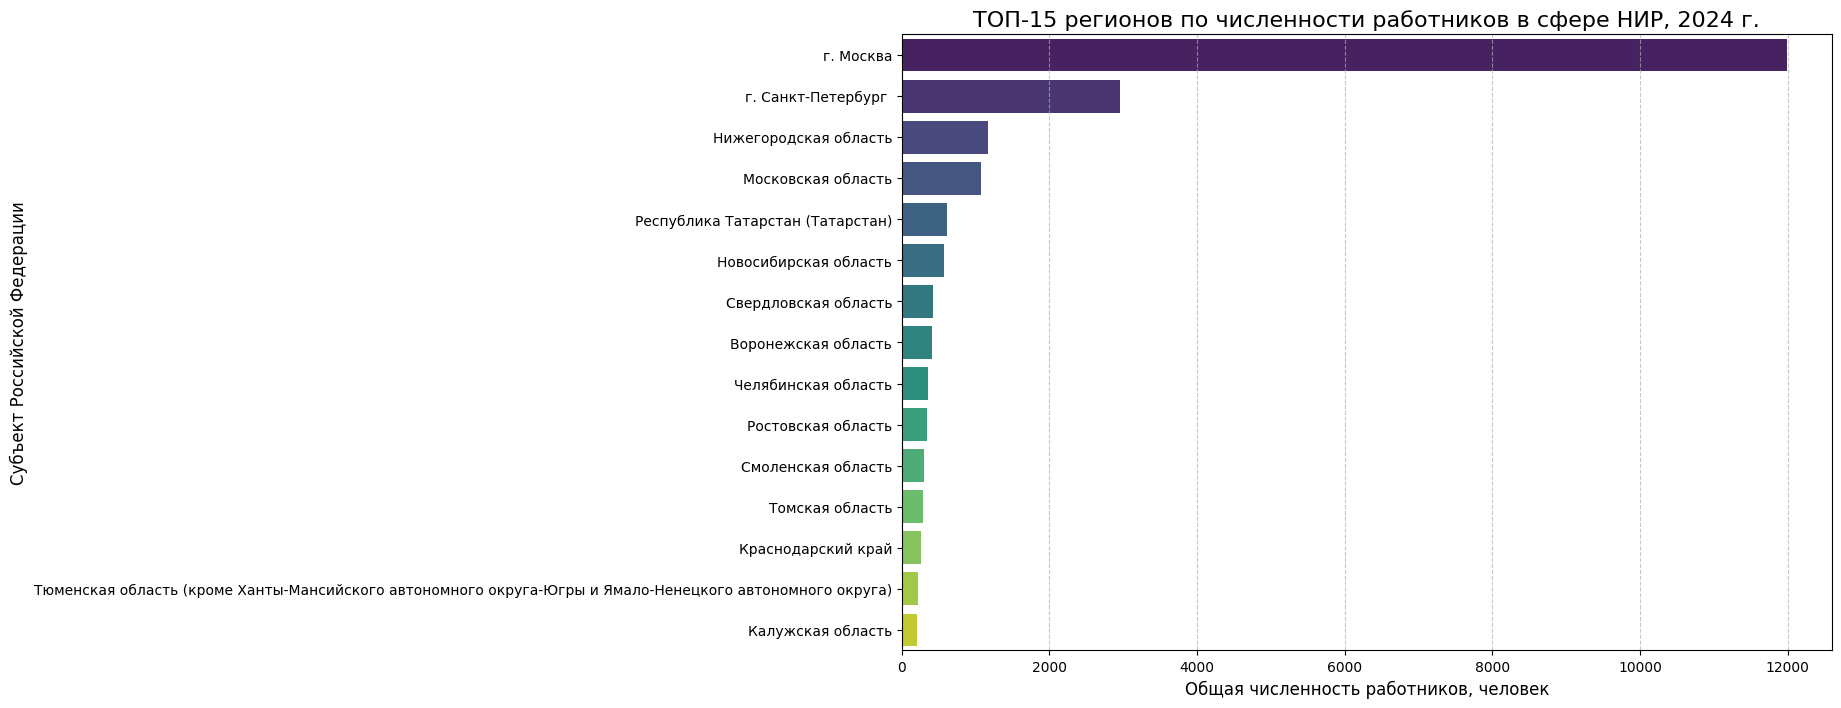

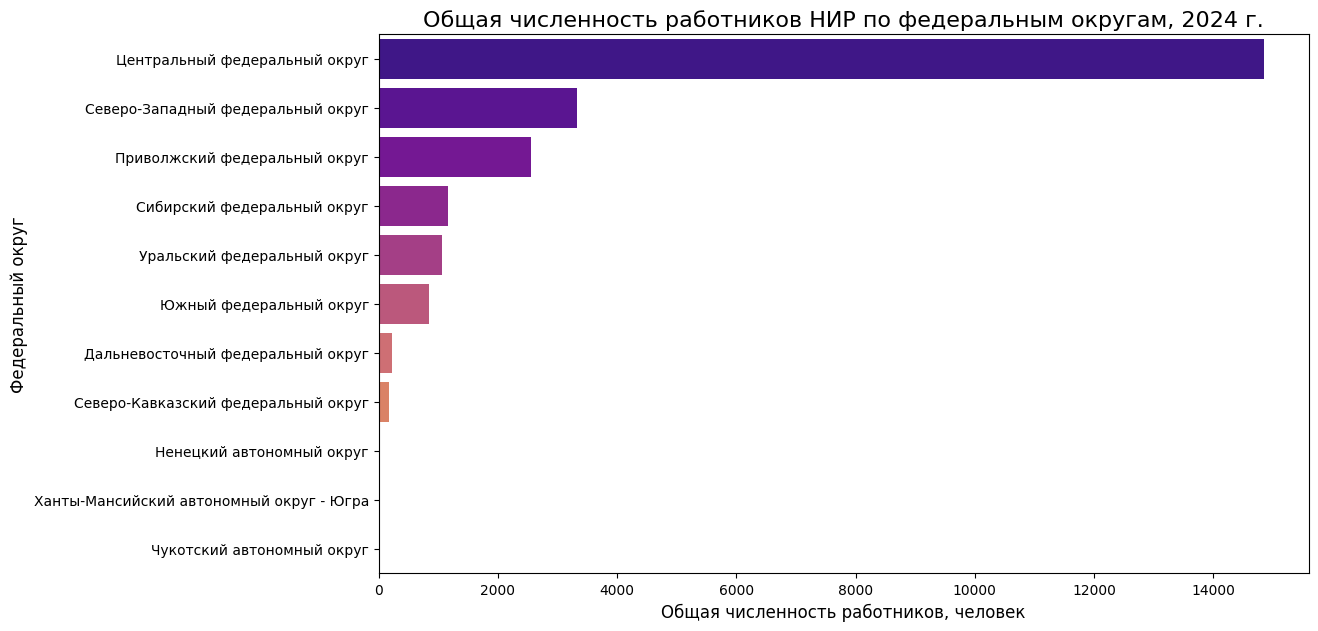

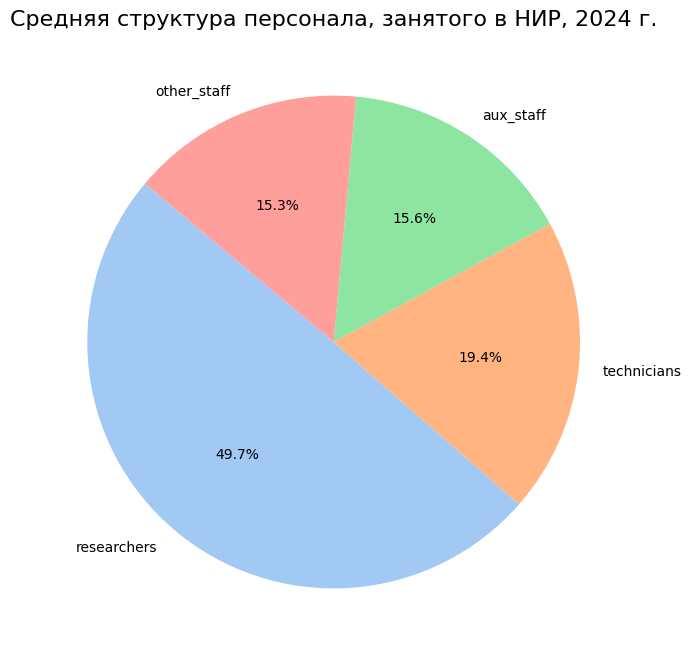

In [44]:
if not df_regions.empty:
    
    # --- График 1: Столбчатая диаграмма лидеров по регионам ---
    top_regions = df_regions.dropna(subset=['total_employees']).sort_values(
        by='total_employees', ascending=False
    ).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='total_employees', y='region', data=top_regions, palette='viridis', hue='region')
    plt.title('ТОП-15 регионов по численности работников в сфере НИР, 2024 г.', fontsize=16)
    plt.xlabel('Общая численность работников, человек', fontsize=12)
    plt.ylabel('Субъект Российской Федерации', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
    # --- ИЗМЕНЕНИЕ: График 2 по федеральным округам ---
    plt.figure(figsize=(12, 7))
    sns.barplot(x='total_employees', y='region', data=df_districts.sort_values('total_employees', ascending=False), palette='plasma', hue='region')
    plt.title('Общая численность работников НИР по федеральным округам, 2024 г.', fontsize=16)
    plt.xlabel('Общая численность работников, человек', fontsize=12)
    plt.ylabel('Федеральный округ', fontsize=12)
    plt.show()

    # --- График 3: Круговая диаграмма структуры персонала ---
    personnel_structure = df_regions[['researchers', 'technicians', 'aux_staff', 'other_staff']].sum()
    plt.figure(figsize=(8, 8))
    plt.pie(personnel_structure, labels=personnel_structure.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Средняя структура персонала, занятого в НИР, 2024 г.', fontsize=16)
    plt.ylabel('')
    plt.show()



По построенным графикам можно определить, что подавляющее большинство работников в сфере НИР при просмотре округов находятся на территории Центрального федерально округа, а при просмотре статистики по регионам заметно, что сосредоточением работников является Москва. Санкт-Петербург находится на втором месте среди регионов. При анализе персонала, занятого в НИР можно заметить, что почти половина сотрудников работают исследователями, остальные сферы деятельности распределены почти одинаково разделяя вторую половину на почти одинаковые трети.

___
## 4. Числовые оценки характеристик данных
___

В этом разделе расчитаем основные числовые характеристики данных по количеству сотрудников, задействованных в сфере НИР.

In [97]:
if not df.empty:
    
    # Для анализа числовых характеристик возьмем столбец 'total_employees'
    data_series = df_regions['total_employees'].dropna()

    mean_val = data_series.mean()
    median_val = data_series.median()
    std_val = data_series.std()
    variance_val = data_series.var()
    range_val = data_series.max() - data_series.min()
    q1 = data_series.quantile(0.25)
    q3 = data_series.quantile(0.75)

    print("\nОсновные числовые характеристики для показателя 'Общая численность работников':")
    print("-" * 80)
    print(f"Среднее арифметическое (Mean): {mean_val:.2f}")
    print("   Формула: Σx / n")
    print("   Интерпретация: Среднее количество сотрудников НИР на один регион составляет примерно "
          f"{mean_val:.0f} человек. Однако это значение сильно завышено из-за влияния регионов-лидеров.")

    print(f"\nМедиана (Median): {median_val:.2f}")
    print("   Формула: Значение, которое делит упорядоченную выборку пополам.")
    print(f"   Интерпретация: 50% регионов имеют численность работников НИР меньше {median_val:.0f}, а 50% — больше. "
          "Это значение гораздо лучше описывает большую часть регионов, чем среднее.")

    print(f"\nСтандартное отклонение (Standard Deviation): {std_val:.2f}")
    print("   Формула: sqrt(Σ(x - μ)² / (n-1))")
    print("   Интерпретация: Очень большое значение указывает на огромный разброс данных. "
          "Численность работников сильно варьируется от региона к региону.")
    
    print(f"\nРазмах (Range): {range_val:.2f}")
    print("   Формула: max(x) - min(x)")
    print("   Интерпретация: Разница между максимальным и минимальным значением. "
          f"Она огромна, что подтверждает наличие сильных выбросов.")

    print(f"\nКвартили: Q1 = {q1:.2f}, Q3 = {q3:.2f}")
    print(f"   Интерпретация: 25% регионов имеют менее {q1:.0f} работников, а 75% — менее {q3:.0f}.")


Основные числовые характеристики для показателя 'Общая численность работников':
--------------------------------------------------------------------------------
Среднее арифметическое (Mean): 642.92
   Формула: Σx / n
   Интерпретация: Среднее количество сотрудников НИР на один регион составляет примерно 643 человек. Однако это значение сильно завышено из-за влияния регионов-лидеров.

Медиана (Median): 158.00
   Формула: Значение, которое делит упорядоченную выборку пополам.
   Интерпретация: 50% регионов имеют численность работников НИР меньше 158, а 50% — больше. Это значение гораздо лучше описывает большую часть регионов, чем среднее.

Стандартное отклонение (Standard Deviation): 2015.42
   Формула: sqrt(Σ(x - μ)² / (n-1))
   Интерпретация: Очень большое значение указывает на огромный разброс данных. Численность работников сильно варьируется от региона к региону.

Размах (Range): 11975.00
   Формула: max(x) - min(x)
   Интерпретация: Разница между максимальным и минимальным значени

___
## 5. Оценка плотности распределения
___

В данном пункте рассчитаем плотность распределения и проведём её анализ.

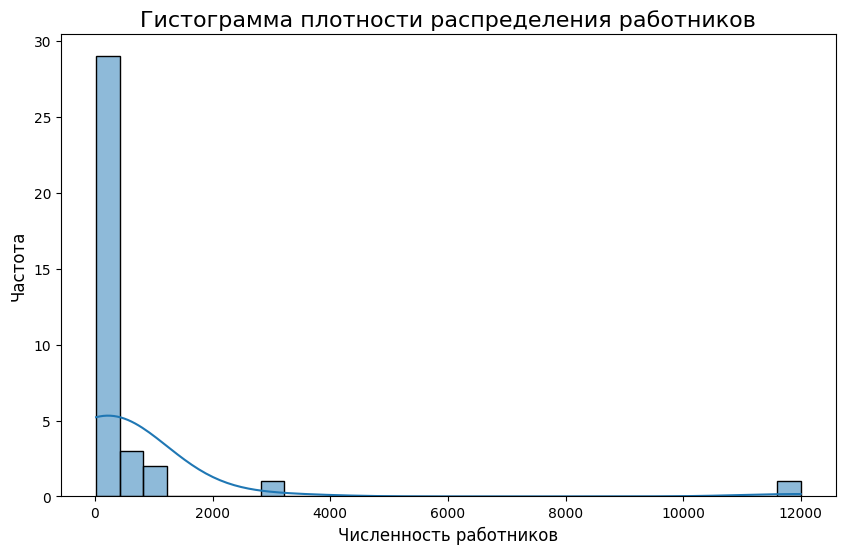


Проверка гипотезы о нормальности распределения:
Статистика теста: 0.2932, p-value: 0.0000
Вывод: p-value < 0.05. Отвергаем нулевую гипотезу, данные не распределены нормально.


In [100]:
if not df.empty:
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data_series, kde=True, bins=30)
    plt.title('Гистограмма плотности распределения работников', fontsize=16)
    plt.xlabel('Численность работников', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.show()

    # --- Проверка гипотезы о характере распределения ---
    shapiro_stat, p_value = stats.shapiro(data_series)
    
    print("\nПроверка гипотезы о нормальности распределения:")
    print(f"Статистика теста: {shapiro_stat:.4f}, p-value: {p_value:.4f}")
    
    alpha = 0.05
    if p_value > alpha:
        print("Вывод: p-value > 0.05. Не можем отвергнуть нулевую гипотезу, данные могут быть распределены нормально.")
    else:
        print("Вывод: p-value < 0.05. Отвергаем нулевую гипотезу, данные не распределены нормально.")


Анализ графика:
- Распределение сильно скошено вправо (положительная асимметрия).
- Большинство регионов имеют небольшое количество работников в сфере НИР.
- Присутствуют "тяжелые хвосты" — регионы с очень высокими значениями, которые являются выбросами.
- Визуально распределение не похоже на нормальное.

___
## 6. Интервальные оценки (доверительные интервалы)
___

Следующим шагом стал расчёт доверительных интервалов. <br>Доверительный интервал — это диапазон значений, который с определённой вероятностью содержит истинное значение исследуемого параметра. 

In [48]:
if not df.empty:
    # Найдем 95% доверительный интервал для среднего значения.
    n = len(data_series)
    mean_val = data_series.mean()
    sem_val = stats.sem(data_series) # Standard Error of the Mean
    confidence_interval = stats.t.interval(0.95, df=n-1, loc=mean_val, scale=sem_val)
    
    print(f"\n95% доверительный интервал для среднего значения:")
    print(f"   Интервал: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
    print("   Формула: μ ± t * (s / sqrt(n))")


95% доверительный интервал для среднего значения:
   Интервал: (-39.00, 1324.84)
   Формула: μ ± t * (s / sqrt(n))
   Интерпретация: Мы на 95% уверены, что истинное среднее значение по всем регионам РФ находится в этом интервале. Однако, из-за ненормальности распределения, эта оценка может быть не очень надежной.


По полученным данным можно быть на на 95% уверенным, что истинное среднее значение по всем регионам РФ находится в этом интервале. Однако, из-за ненормальности распределения, эта оценка может быть не очень надежной.

___
## 7. Сравнение со статистикой за 2023 год
___

В качестве дополнительного исследования проведём сравнение со статистикой за 2023 год для определения характера изменений.

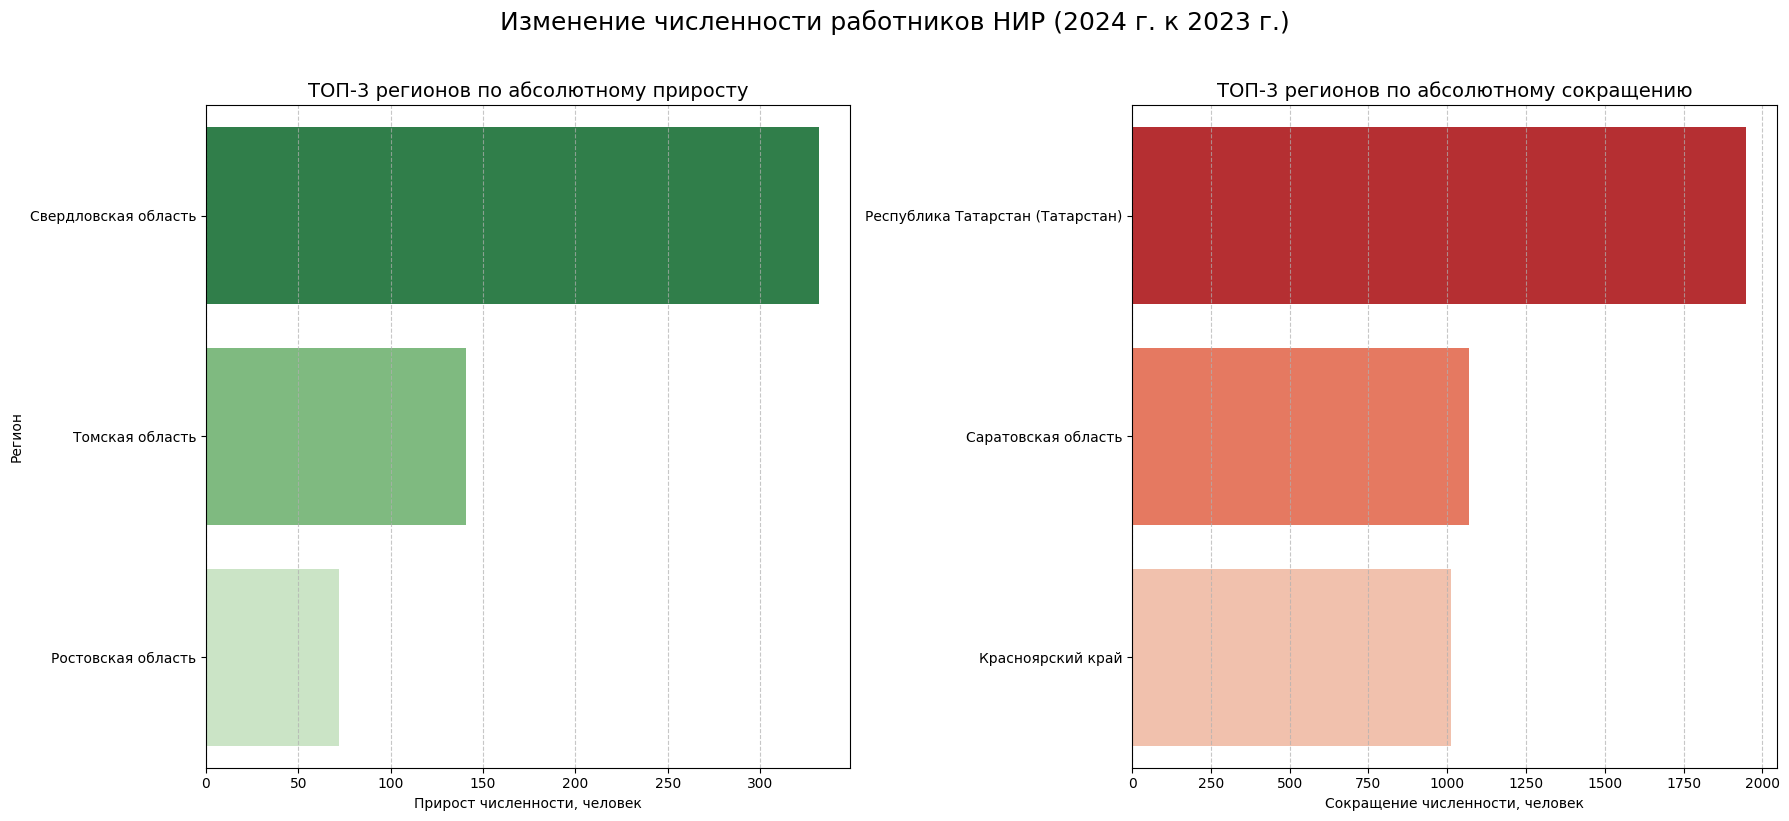

In [101]:
# Загружаем данные за 2023 год
file_path_2023 = '2-MP-nauka_2023.xlsx'
column_names_2023 = [
'region', 'num_enterprises', 'total_employees',
'researchers', 'technicians', 'aux_staff', 'other_staff',
'researchers_under_39', 'gov_contract_enterprises'
]
columns_to_read_2023 = 'A,C:J'
df_2023 = pd.read_excel(file_path_2023, sheet_name='таблица 1', names=column_names_2023, usecols=columns_to_read_2023, skiprows=7, thousands=' ')
# Заменяются нечисловые маркеры пропусков ('‒', '...') на специальное значение NaN (Not a Number), которое pandas умеет корректно обрабатывать.
df_2023.replace(['‒', '...'], np.nan, inplace=True)

# Преобразуются все столбцы, кроме первого (название региона), в числовой формат.
# 'coerce' означает, что если значение не может быть преобразовано в число, оно станет NaN.
for col in df.columns[1:]:
    df_2023[col] = pd.to_numeric(df[col], errors='coerce')
        
# Удаляем строки, где нет вообще никаких данных (полностью пустые)
df_2023.dropna(how='all', inplace=True)
    
# Отдельный DataFrame `df_regions`, который содержит данные только по отдельным субъектам РФ, исключая строки с агрегированными данными по федеральным округам и всей стране.
federal_districts = [
    "Центральный федеральный округ", "Северо-Западный федеральный округ",
    "Южный федеральный округ", "Северо-Кавказский федеральный округ",
    "Приволжский федеральный округ", "Уральский федеральный округ",
    "Сибирский федеральный округ", "Дальневосточный федеральный округ",
    "Ненецкий автономный округ", "Ханты-Мансийский автономный округ - Югра",
    "Ямало-Ненецкий автономный округ", "Чукотский автономный округ" 
]

# Убираются строки с названием страны, округов и пустые строки в названии региона
df_regions_2023 = df_2023[
    ~df_2023['region'].isin(['Российская Федерация '] + federal_districts) &
    df_2023['region'].notna()
].reset_index(drop=True)
df_regions_2023 = df_regions_2023.iloc[:-2]

change_df['change_direction'] = np.where(change_df['abs_change'] > 0, 'Рост', 'Падение')
if not df_regions_2023.empty and not df_regions.empty:
    # Объединяем данные за два года в одну таблицу
    df_comparison = pd.merge(
        df_regions_2023,
        df_regions,
        on='region',
        suffixes=('_2023', '_2024'),
        how='outer' # outer join, чтобы сохранить все регионы
    )

    # Рассчитываем абсолютное и относительное изменение численности
    df_comparison['abs_change'] = df_comparison['total_employees_2024'] - df_comparison['total_employees_2023']
    df_comparison['rel_change_%'] = (df_comparison['abs_change'] / df_comparison['total_employees_2023']) * 100
    df_comparison.replace([np.inf, -np.inf], np.nan, inplace=True) # Убираем бесконечности (деление на 0)

    # --- ИЗМЕНЕНИЕ: Визуализация изменений на двух отдельных графиках ---
    top_growth = df_comparison.dropna(subset=['abs_change']).sort_values('abs_change', ascending=False).head(3)
    top_decline = df_comparison.dropna(subset=['abs_change']).sort_values('abs_change', ascending=True).head(3)
    
    # Создаем фигуру с двумя подграфиками
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # График для регионов с наибольшим ростом
    sns.barplot(ax=axes[0], x='abs_change', y='region', data=top_growth, palette='Greens_r', hue ='region')
    axes[0].set_title('ТОП-3 регионов по абсолютному приросту', fontsize=14)
    axes[0].set_xlabel('Прирост численности, человек')
    axes[0].set_ylabel('Регион')
    axes[0].grid(axis='x', linestyle='--', alpha=0.7)

    # График для регионов с наибольшим падением
    # Для падения делаем значения положительными для наглядности и меняем подпись оси
    top_decline['abs_change_positive'] = top_decline['abs_change'] * -1
    sns.barplot(ax=axes[1], x='abs_change_positive', y='region', data=top_decline.sort_values('abs_change'), palette='Reds_r', hue ='region')
    axes[1].set_title('ТОП-3 регионов по абсолютному сокращению', fontsize=14)
    axes[1].set_xlabel('Сокращение численности, человек')
    axes[1].set_ylabel('') # Убираем дублирующую подпись
    axes[1].grid(axis='x', linestyle='--', alpha=0.7)

    # Общий заголовок
    fig.suptitle('Изменение численности работников НИР (2024 г. к 2023 г.)', fontsize=18, y=1.02)
    
    plt.tight_layout()
    plt.show()

Выводы по сравнению с 2023 годом:
- График показывает регионы с самым значительным ростом (зеленый цвет) и падением (красный цвет) численности персонала в сфере НИР.
- Свердловская область демонстрирует наибольший абсолютный прирост, что показывает увеличение финансирования регионов.
- Некоторые регионы, такие как Республика Татарстан и Саратовская область показали сильный спад, что может свидетельствовать о перераспределении кадров в другие регионы или в научные центры, относящиеся к другим регионам
- В целом по стране наблюдается рост, что видно по суммарным показателям в исходных данных
      (24222 чел. в 2024 г. против 20165 чел. в 2023 г.).

___
## Вывод
___

**При выполнении практической работы было выяснено, что характер распределения не удаётся проследить, так как данные по численности работников НИР в регионах РФ крайне неоднородны и имеют сильную положительную асимметрию. Гипотеза о нормальности распределения была отвергнута. В используемых данных было обнаружено множество выбросов, что говорит о неравномерности распределения: присутствуют ярко выраженные выбросы (г. Москва, г. Санкт-Петербург), которые сильно искажают среднее значение. Прослеживается сильная территориальная концентрация, а именно то что научная активность малых предприятий сконцентрирована в Центральном ФО, что подтверждается как суммарными показателями, так и более высокими медианными значениями по регионам внутри этого округа. После сравнения статистики за два года можно с уверенностью сказать, что динамика 2023-2024 гг. положительная - наблюдается общий рост численности занятых в НИР. Однако в ряде регионов наблюдается и отрицательная динамика.**